# Building Frederike's second force field

In [1]:
import matplotlib.pyplot as plt

from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.optimize import BFGS
Fit_on_forces=True

### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


for i in {1..19}; do (mkdir "outcar${i}"; mv "outcar${i}.txt" "outcar${i}/OUTCAR"); done
for i in {1..19}; do (echo "outcar/outcar${i}" >> data_list.txt); done
for f in $(ls OUTCARS/); do echo "OUTCARS/$f" >> data_list.txt; done

In [44]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="DFT.db",file_list="data_list.txt",overwrite=True, greedy=False)

    Building data-bases: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 108.15it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [45]:
!ase db DFT.db

id|age|user    |formula    |calculator|  energy|natoms| fmax|pbc| volume|charge|    mass| smax|magmom
 1| 6s|thism292|Li13Ni27O54|vasp      |-574.107|    94|0.018|TTT|868.408| 0.000|2538.888|0.001| 9.359
 2| 6s|thism292|Li17Ni27O54|vasp      |-595.854|    98|0.018|TTT|884.767| 0.000|2566.648|0.001|17.010
 3| 6s|thism292|Li20Ni27O54|vasp      |-611.175|   101|0.013|TTT|888.860| 0.000|2587.468|0.001|20.000
 4| 6s|thism292|Li4Ni27O54 |vasp      |-528.892|    85|0.011|TTT|856.196| 0.000|2476.428|0.000| 3.992
 5| 6s|thism292|Li7Ni27O54 |vasp      |-545.210|    88|0.015|TTT|863.845| 0.000|2497.248|0.000| 4.935
 6| 6s|thism292|Li18Ni27O54|vasp      |-601.983|    99|0.019|TTT|884.190| 0.000|2573.588|0.001|18.004
 7| 6s|thism292|Li20Ni27O54|vasp      |-611.432|   101|0.014|TTT|887.953| 0.000|2587.468|0.000|19.985
 8| 6s|thism292|Li16Ni27O54|vasp      |-591.886|    97|0.020|TTT|886.356| 0.000|2559.708|0.000|16.000
 9| 6s|thism292|Li15Ni27O54|vasp      |-586.868|    96|0.019|TTT|887.602| 0.000|25

In [4]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="DFT.db",include_forces=Fit_on_forces)

    Fetching data: 100%|█████████████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 59.47it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [29]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [30]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Generating two-body potentials from one-body information.
    Adding pair: Li-Ni
    Adding pair: Li-O
    Adding pair: Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Merging interval for pair Ni-Ni. Number of knots reduced from 15 to 9. 
    Merging interval for pair Li-Li. Number of knots reduced from 15 to 12. 
    Merging interval for pair Li-Ni. Number of knots reduced from 12 to 10. 
    Merging interval for pair Li-O. Number of knots reduced from 18 to 13. 
    Merging interval for pair Ni-O. Number of knots reduced from 19 to 12. 
    There is linear dependence in stochiometry matrix!
    Removing onebody t

    Finding optimum switch: 100%|███████████████████████████████████████████████████████| 1560/1560 [00:15<00:00, 100.14it/s]


    The best switch is (16, 9, 12, 2, 2, 2) with mse: 0.027812, corresponding to distances of [6.3  4.87 5.55 3.09 2.32 2.22] Å for element pairs ['O-O', 'Ni-Ni', 'Li-Li', 'Li-Ni', 'Li-O', 'Ni-O'].
    Final root mean square error in energy:  0.0008998329249776415  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 2nd iteration of fitting

In [31]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.09,
                        "range_width": 1.0 # Å
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.32,
                        "range_width": 1.0 # Å
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.22,
                        "range_width": 1.0 # Å
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [32]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 27 to 18. 
    Merging interval for pair Li-O. Number of knots reduced from 43 to 26. 
    Merging interval for pair Ni-O. Number of knots reduced from 44 to 25. 
    Merging interval for pair O-O. Number of knots reduced from 37 to 34. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 33 to 14. 
    Merging interval for pair Li-Li. Number of knots reduced from 35 to 24. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range search turned on for element pair Li

    Finding optimum switch: 100%|██████████████████████████████████████████████████████████| 144/144 [00:02<00:00, 48.69it/s]


    The best switch is (4, 4, 1, 34, 14, 24) with mse: 0.026558, corresponding to distances of [3.07 2.29 1.89 5.78 4.1  5.02] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008902243935310905  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 3rd iteration

In [33]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.07,
                        "range_width": 0.2 # Å
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.29,
                        "range_width": 0.2 # Å
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.89,
                        "range_width": 0.4 # Å
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [34]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 125 to 73. 
    Merging interval for pair Li-O. Number of knots reduced from 205 to 104. 
    Merging interval for pair Ni-O. Number of knots reduced from 210 to 94. 
    Merging interval for pair O-O. Number of knots reduced from 37 to 34. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 33 to 14. 
    Merging interval for pair Li-Li. Number of knots reduced from 35 to 24. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range search turned on for element pai

    Finding optimum switch: 100%|██████████████████████████████████████████████████████████| 756/756 [00:38<00:00, 19.64it/s]


    The best switch is (18, 20, 4, 34, 14, 24) with mse: 0.025823, corresponding to distances of [3.07 2.33 1.91 5.78 4.1  5.02] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008728911662810492  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 4th iteration

In [35]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [3.07]
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [2.33]
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [1.91]
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.2,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.2,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.2,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [36]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 125 to 73. 
    Merging interval for pair Li-O. Number of knots reduced from 205 to 104. 
    Merging interval for pair Ni-O. Number of knots reduced from 210 to 94. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 18 to 9. 
    Merging interval for pair Li-Li. Number of knots reduced from 19 to 14. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Switch points located at [3.09] Å to for element pair Li-Ni based on point search.
    Switch points located at [2

    Finding optimum switch: 100%|████████████████████████████████████████████████████████| 2520/2520 [02:22<00:00, 17.68it/s]


    The best switch is (19, 20, 4, 2, 2, 12) with mse: 0.025551, corresponding to distances of [3.09 2.33 1.91 2.73 3.05 4.97] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008266044938723393  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 6th iteration

In [39]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.09,
                        "range_width": 0.5
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.33,
                        "range_width": 0.5
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.91,
                        "range_width": 0.5
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.73,
                        "range_width": 0.5
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.05,
                        "range_width": 0.5
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.97,
                        "range_width": 0.5
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [40]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 27 to 18. 
    Merging interval for pair Li-O. Number of knots reduced from 43 to 26. 
    Merging interval for pair Ni-O. Number of knots reduced from 44 to 25. 
    Merging interval for pair O-O. Number of knots reduced from 37 to 34. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 33 to 14. 
    Merging interval for pair Li-Li. Number of knots reduced from 35 to 24. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range search turned on for element pair Li

    Finding optimum switch: 100%|████████████████████████████████████████████████████████| 1600/1600 [00:27<00:00, 58.61it/s]


    The best switch is (4, 4, 1, 4, 2, 22) with mse: 0.025997, corresponding to distances of [3.07 2.29 1.89 2.78 2.9  4.82] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008588828540500159  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 7th iteration

In [45]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.07,
                        "range_width": 0.1
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.29,
                        "range_width": 0.1
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.89,
                        "range_width": 0.1
                },
                "O-O": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.78,
                        "range_width": 0.1
                },
                "Ni-Ni": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.9,
                        "range_width": 0.1
                },
                "Li-Li": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.82,
                        "range_width": 0.1
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [46]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 125 to 73. 
    Merging interval for pair Li-O. Number of knots reduced from 205 to 104. 
    Merging interval for pair Ni-O. Number of knots reduced from 210 to 94. 
    Merging interval for pair O-O. Number of knots reduced from 178 to 151. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 159 to 56. 
    Merging interval for pair Li-Li. Number of knots reduced from 168 to 109. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range search turned on for elemen

    Finding optimum switch: 100%|████████████████████████████████████████████████████████| 9375/9375 [28:49<00:00,  5.42it/s]


    The best switch is (18, 20, 4, 20, 8, 107) with mse: 0.025104, corresponding to distances of [3.07 2.33 1.91 2.82 2.9  4.8 ] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008392108616140276  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 8th iteration

In [47]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [3.07]
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [2.33]
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [1.91]
                },
                "O-O": {
                        "Rcut": 8.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [2.82]
                },
                "Ni-Ni": {
                        "Rcut": 8.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [2.9]
                },
                "Li-Li": {
                        "Rcut": 8.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [4.9]
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [48]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 248 to 137. 
    Merging interval for pair Li-O. Number of knots reduced from 408 to 200. 
    Merging interval for pair Ni-O. Number of knots reduced from 418 to 173. 
    Merging interval for pair O-O. Number of knots reduced from 354 to 297. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 316 to 101. 
    Merging interval for pair Li-Li. Number of knots reduced from 334 to 205. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Switch points located at [3.07

    Finding optimum switch: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


    The best switch is (36, 40, 8, 40, 194, 224) with mse: 0.025366, corresponding to distances of [3.07 2.34 1.92 2.82 4.68 4.91] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008624415381833482  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [49]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="DFT.db")

100%|██████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:11<00:00, 24.00it/s]


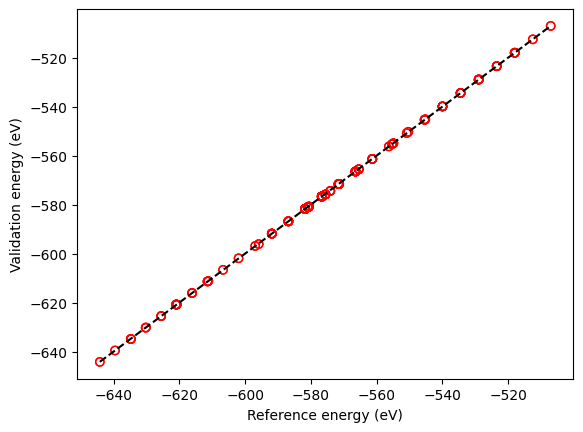

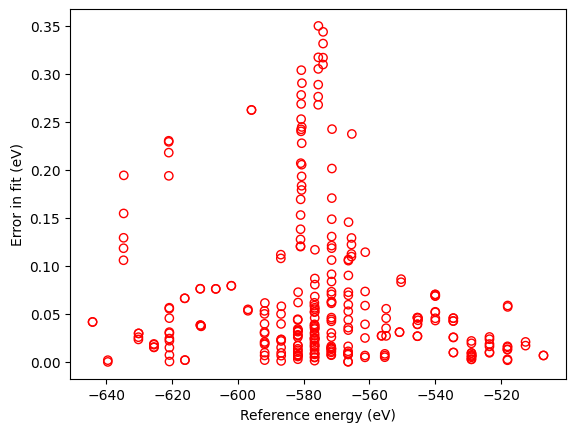

In [50]:
try:
    err=np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

### Cleaning up

In [11]:
# import glob

# def rm(file):
#     try:
#         os.remove(file)
#     except OSError:
#         pass


# list=glob.glob("CALCULATED_DATA/*")
# for file in list:
#     rm(file)
# list=glob.glob("CCS_*")
# for file in list:
#     rm(file)
# list=glob.glob("UNC_*")
# for file in list:
#     rm(file)
# rm("structures.json")
# rm("file_list")
# rm("LJ.db")

### Convex hull

Text(0, 0.5, 'Energy')

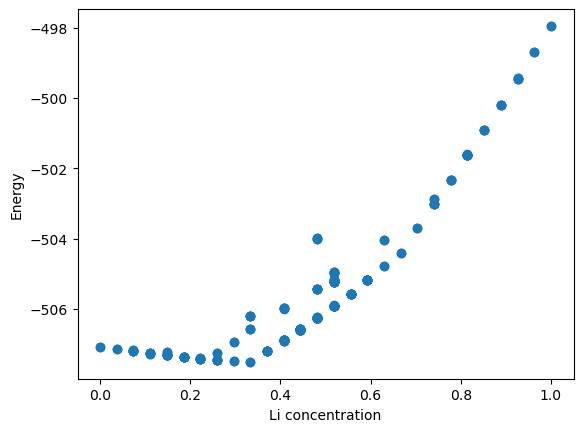

In [13]:
# CCS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS 
from ase import io
import json
import ase.db as db

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

nrg_Li = CCS_params['One_body']['Li'] + 0.335
    
CCS_calc=CCS(CCS_params=CCS_params)
    
DFT_DB = db.connect('DFT.db')
    
xs = []
CCS_nrgs = []

i = 0

for row in DFT_DB.select():
    structure = row.toatoms()
    # print(structure.get_magnetic_moments())
    elems = structure.get_chemical_symbols()
    nr_Li = elems.count('Li')
    nr_Ni = elems.count('Ni')
    x = nr_Li/nr_Ni
    EDFT = structure.get_potential_energy()
    structure.calc = CCS_calc
    ECCS = structure.get_potential_energy() - nr_Li*nrg_Li
    xs.append(x)
    CCS_nrgs.append(ECCS)
    i += 1

plt.scatter(xs, CCS_nrgs)
plt.xlabel("Li concentration")
plt.ylabel("Energy")

0 0.48148148148148145
1 0.6296296296296297
2 0.7407407407407407
3 0.14814814814814814
4 0.25925925925925924
5 0.6666666666666666
6 0.7407407407407407
7 0.5925925925925926
8 0.5555555555555556
9 0.2962962962962963
10 1.0
11 0.37037037037037035
12 0.6296296296296297
13 0.14814814814814814
14 0.037037037037037035
15 0.8888888888888888
16 0.18518518518518517
17 0.8518518518518519
18 0.2222222222222222
19 0.7037037037037037
20 0.4444444444444444
21 0.0
22 0.07407407407407407
23 0.4074074074074074
24 0.18518518518518517
25 0.4444444444444444
26 0.25925925925925924
27 0.14814814814814814
28 0.8148148148148148
29 0.48148148148148145
30 0.3333333333333333
31 0.2962962962962963
32 0.5185185185185185
33 0.25925925925925924
34 0.8148148148148148
35 0.2222222222222222
36 0.07407407407407407
37 0.5925925925925926
38 0.5555555555555556
39 0.18518518518518517
40 0.4444444444444444
41 0.1111111111111111
42 0.14814814814814814
43 0.4074074074074074
44 0.48148148148148145
45 0.4074074074074074
46 0.51851

Text(0, 0.5, 'Energy')

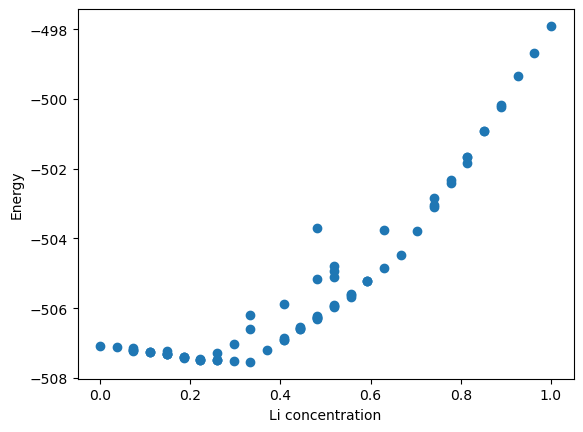

In [46]:
# CCS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS 
from ase import io
import json
import ase.db as db

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

nrg_Li = CCS_params['One_body']['Li']
    
CCS_calc=CCS(CCS_params=CCS_params)
    
DFT_DB = db.connect('DFT.db')
    
xs = []
DFT_nrgs = []

i = 0

for row in DFT_DB.select():
    structure = row.toatoms()
    # print(i)
    # print(dir(structure))
    # print(structure.get_magnetic_moment())
    elems = structure.get_chemical_symbols()
    nr_Li = elems.count('Li')
    nr_Ni = elems.count('Ni')
    x = nr_Li/nr_Ni
    print(i,x)
    EDFT = structure.get_potential_energy() - nr_Li*nrg_Li
    xs.append(x)
    DFT_nrgs.append(EDFT)
    i += 1

plt.scatter(xs, DFT_nrgs)
plt.xlabel("Li concentration")
plt.ylabel("Energy")

In [ ]:
def get_mixing_energy(atoms):
    # Set the correct cell size from the lattice constant
    new_a = get_avg_lattice_constant(atoms.get_chemical_symbols())
    # Use the orthogonal fcc cell to find the current lattice constant
    current_a = atoms.cell[0][0] / np.sqrt(2)
    atoms.set_cell(atoms.cell * new_a / current_a, scale_atoms=True)

    # Calculate the energy
    atoms.calc = CCS_calc
    e = atoms.get_potential_energy()

    # Subtract contributions from the pure element references
    # to get the mixing energy
    syms = atoms.get_chemical_symbols()
    for m in set(syms):
        e -= syms.count(m) * refs[m]
    return e

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.phasediagram import PhaseDiagram
from ase.db import connect
from ase.io import write

db = connect('DFT.db')

# Select the evaluated candidates and retrieve the chemical formula and mixing
# energy for the phase diagram
refs = []
dcts = list(db.select('relaxed=1'))
for dct in dcts:
    refs.append((dct.formula, -dct.raw_score))

pd = PhaseDiagram(refs)
ax = pd.plot(show=not True,  # set to True to show plot
             only_label_simplices=True)
plt.savefig('hull.png')

# View the simplices of the convex hull
simplices = []
toview = sorted(np.array(dcts)[pd.hull], key=lambda x: x.mass)
for dct in toview:
    simplices.append(dct.toatoms())

write('hull.traj', simplices)

ValueError: You must provide a non-empty list of references for the phase diagram! You have provided '[]'

In [49]:
from ase.optimize import BFGS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from tqdm import tqdm
from ase import io

struct = io.read('DFT.db@21')

struct = struct * [2,2,2]

CCS_calc = CCS(CCS_params=CCS_params)

struct.calc = CCS_calc

opt = BFGS(struct, trajectory='opt.traj')
opt.run(fmax=0.0001)

      Step     Time          Energy         fmax
BFGS:    0 12:17:47    -4056.674396        0.0039
BFGS:    1 12:17:48    -4056.674488        0.0038
BFGS:    2 12:17:49    -4056.685755        0.0001


True

In [50]:
from ase.constraints import StrainFilter

sf = StrainFilter(struct)
opt = BFGS(sf)
opt.run(0.005)

      Step     Time          Energy         fmax
BFGS:    0 12:20:11    -4056.685755        0.0000


True

In [35]:
!ase gui opt.traj

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/pipe.py", line 19, in main
    make_plot(show=False, *data)
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/graphs.py", line 78, in make_plot
    plt.figure(figsize=(basesize * 2.5**0.5, basesize))
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/_api/deprecation.py", line 454, in wrapper
    return func(*args, **kwargs)
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", line 783, in figure
    manager = new_figure_manager(
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", 

In [40]:
!ase gui DFT.db

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/pipe.py", line 19, in main
    make_plot(show=False, *data)
  File "/home/thism292/.local/lib/python3.10/site-packages/ase/gui/graphs.py", line 78, in make_plot
    plt.figure(figsize=(basesize * 2.5**0.5, basesize))
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/_api/deprecation.py", line 454, in wrapper
    return func(*args, **kwargs)
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", line 783, in figure
    manager = new_figure_manager(
  File "/home/thism292/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", 

Buckingham fit (not optimised) for element pair Li-Ni;     V(r) = -5.00*exp(-1.92*r) -(-9.78)/r^6.
Lennard Jones fit (not optimised) for element pair Li-Ni;  V(r) = 4*0.01*((1.99/r)^12 - (1.99/r)^6)
Morse fit (not optimised) for element pair Li-Ni;          V(r) = 0.00*(1-np.exp(-4.19*(r-2.87)))^2 + -0.00


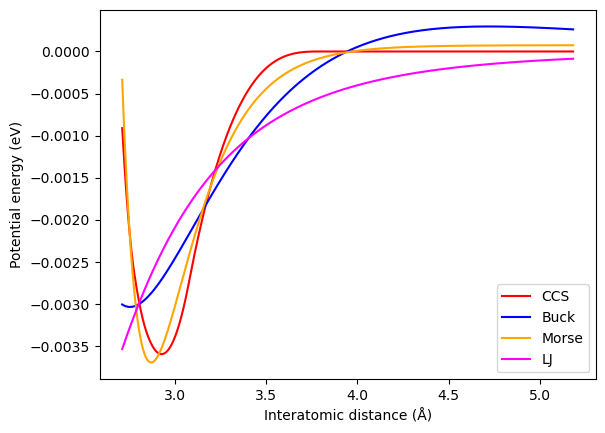

Buckingham fit (not optimised) for element pair Li-O;     V(r) = -10.30*exp(-2.59*r) -(-2.96)/r^6.
Lennard Jones fit (not optimised) for element pair Li-O;  V(r) = 4*0.02*((1.58/r)^12 - (1.58/r)^6)
Morse fit (not optimised) for element pair Li-O;          V(r) = 0.01*(1-np.exp(-4.01*(r-2.03)))^2 + -0.01


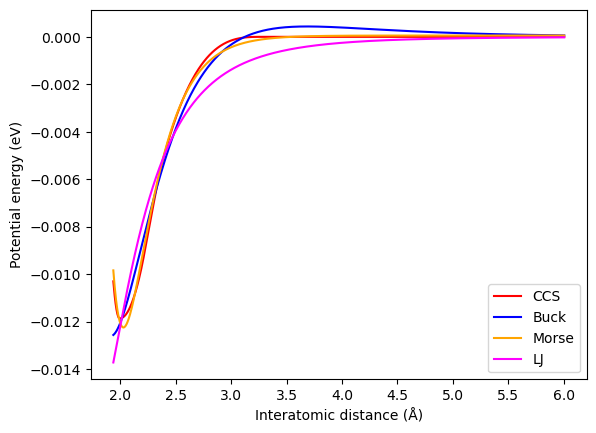

Buckingham fit (not optimised) for element pair Ni-O;     V(r) = -0.67*exp(-1.42*r) -(-0.84)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-O;  V(r) = 4*0.03*((1.77/r)^12 - (1.77/r)^6)
Morse fit (not optimised) for element pair Ni-O;          V(r) = 0.03*(1-np.exp(-1.33*(r-1.67)))^2 + -0.03


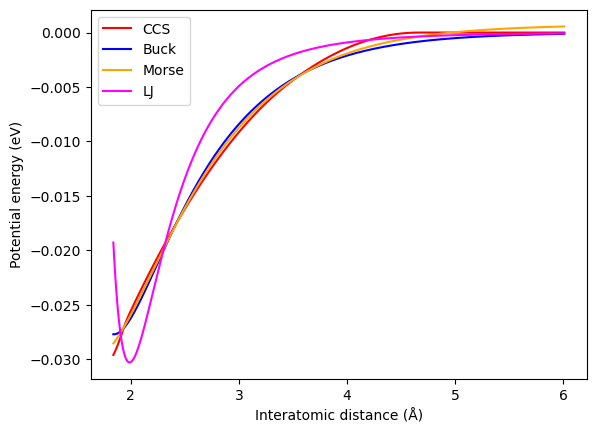

Buckingham fit (not optimised) for element pair O-O;     V(r) = -1.37*exp(-1.85*r) -(-3.55)/r^6.
Lennard Jones fit (not optimised) for element pair O-O;  V(r) = 4*-28.38*((0.32/r)^12 - (0.32/r)^6)
Morse fit (not optimised) for element pair O-O;          V(r) = 0.00*(1-np.exp(-4.24*(r-0.25)))^2 + -0.00


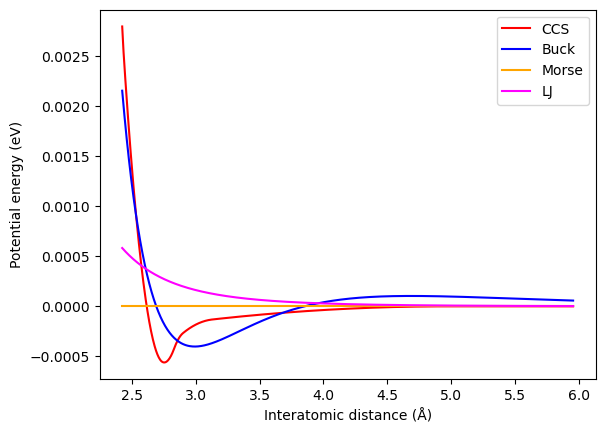

Buckingham fit (not optimised) for element pair Ni-Ni;     V(r) = -0.27*exp(-1.68*r) -(-1.34)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-Ni;  V(r) = 4*-7.68*((0.36/r)^12 - (0.36/r)^6)
Morse fit (not optimised) for element pair Ni-Ni;          V(r) = 0.00*(1-np.exp(-3.01*(r-0.11)))^2 + 0.00


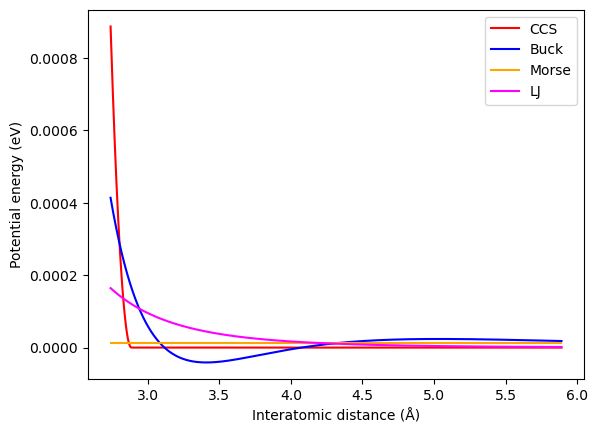

Buckingham fit (not optimised) for element pair Li-Li;     V(r) = 17.16*exp(-1.44*r) -(81.75)/r^6.
Lennard Jones fit (not optimised) for element pair Li-Li;  V(r) = 4*-0.14*((2.48/r)^12 - (2.48/r)^6)
Morse fit (not optimised) for element pair Li-Li;          V(r) = 0.00*(1-np.exp(-5.09*(r-0.04)))^2 + 0.04


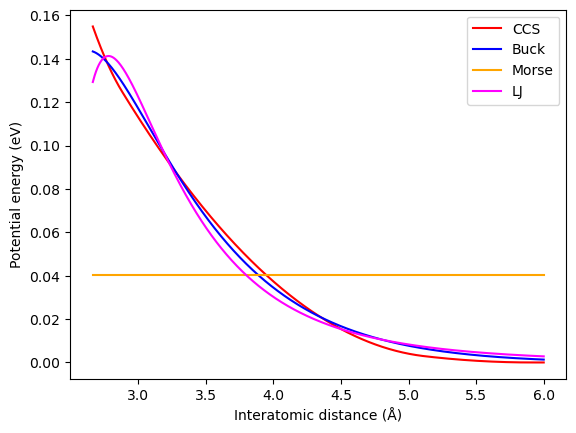

In [42]:
from ccs_fit.scripts.ccs_export_FF import write_FF

write_FF("CCS_params.json")